In [43]:
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da
import dask
from lamade.decomp.power_method import PowerMethod
from lamade.decomp.svd_init import _project_accuracy, _logbase
import time
import datetime

In [2]:
datetime.datetime.now()

datetime.datetime(2020, 1, 27, 12, 55, 35, 154276)

In [103]:
"""
Suppose A is an array of size (m, n)
Using Block Power Method we want to find Truncated Singular Value Decompsition
"""
m, n = 3000, 1000
A = np.random.rand(m, n) - 1.205*np.random.uniform(size=(m,n))
U, S, V = np.linalg.svd(A)
S = np.array(S)
A = A.T.dot(A)
A = da.array(A)

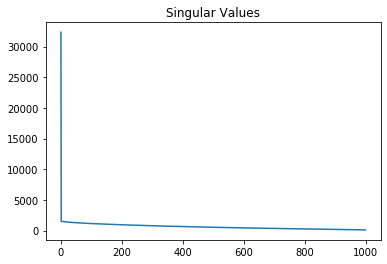

In [104]:
U, S, V = np.linalg.svd(A)
plt.plot(S)
plt.title('Singular Values')
plt.show()

In [105]:
def expected_iters(PM_instance, S):
    delta_epsilon = PM_instance.logs['tol'][-1]/PM_instance.logs['tol'][1]
    eigen_gap = S[PM_instance.k + PM_instance.buffer -1]/S[PM_instance.k-1]
    if isinstance(eigen_gap, da.core.Array):
        eigen_gap = eigen_gap.compute()
    print('log_{}({})'.format(eigen_gap, delta_epsilon))
    return _logbase(delta_epsilon, eigen_gap)

In [117]:
b_range = list(range(5, 40))
k = 10
re_runs = 1
iters = []
times = []
tols = []
e_iters = []
for b in b_range:
    sub_times = []
    sub_iters = []
    sub_tols = []
    sub_e_iters = []
    for _ in range(re_runs):
        PM = PowerMethod(max_iter=200, k=k, buffer=b, scoring_tol=1e-9, init_row_sampling_factor=1)
        start = time.time()
        _, _, _ = PM.svd(A)
        sub_times.append(time.time() - start )
        sub_iters.append(len(PM.logs['tol']))
        sub_tols.append(PM.logs['tol'])
        sub_e_iters.append(expected_iters(PM, S))
    e_iters.append(sub_e_iters)
    iters.append(np.array(sub_iters))
    times.append(np.array(sub_times))
    tols.append(sub_tols)

Normal Start Method
log_0.9782121121797652(3.234201891669113e-11)
Normal Start Method
log_0.9760010433325553(3.9265828874901426e-12)
Normal Start Method
log_0.9744930652838755(4.104707605555007e-12)
Normal Start Method
log_0.9661068982066459(3.912057767468628e-12)
Normal Start Method
log_0.9599623933065738(4.1251058387603135e-12)
Normal Start Method
log_0.9583605427676288(4.238338319240219e-12)
Normal Start Method
log_0.954510348489369(3.5960129634392905e-12)
Normal Start Method
log_0.9531010769661848(3.745623166734418e-12)
Normal Start Method
log_0.9483350303881583(4.07744394865846e-12)
Normal Start Method
log_0.9474017566930893(3.8150895240495244e-12)
Normal Start Method
log_0.9449944835335999(3.6160549040994014e-12)
Normal Start Method
log_0.9416848674194152(4.333702755958714e-12)
Normal Start Method
log_0.9411545431905157(4.5877317882081556e-12)
Normal Start Method
log_0.9369277268363757(4.147970868420207e-12)
Normal Start Method
log_0.9332560201747006(3.702391474577776e-12)
Normal

In [118]:
b_big_range = list(range(5, 200, 10))
k = 10
re_runs = 1
big_iters = []
big_times = []
big_tols = []
for b in b_big_range:
    sub_times = []
    sub_iters = []
    sub_tols = []
    for _ in range(re_runs):
        PM = PowerMethod(max_iter=200, k=k, buffer=b, scoring_tol=1e-9, init_row_sampling_factor=4)
        start = time.time()
        _, _, _ = PM.svd(A)
        sub_times.append(time.time() - start )
        sub_iters.append(len(PM.logs['tol']))
        sub_tols.append(PM.logs['tol'])
    big_iters.append(np.array(sub_iters))
    big_times.append(np.array(sub_times))
    big_tols.append(sub_tols)

Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method
Normal Start Method


# Tolerance Plot

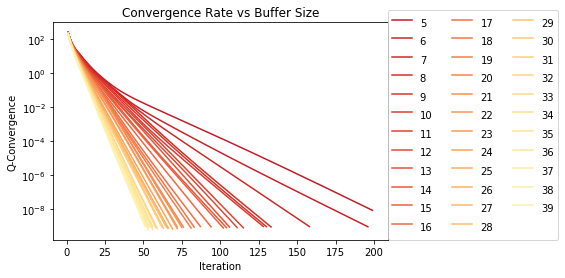

In [119]:
for b, tol_list in zip(b_range, tols):
    plt.plot(np.mean(tol_list, axis=0)[0:200], c = plt.cm.RdYlBu(3*b), label = str(b))
    

plt.yscale('log')
plt.ylabel('Q-Convergence')
plt.xlabel('Iteration')
plt.title('Convergence Rate vs Buffer Size')
plt.legend(loc=(1,0),ncol=3,handleheight=2.4, labelspacing=0.05)
plt.show()

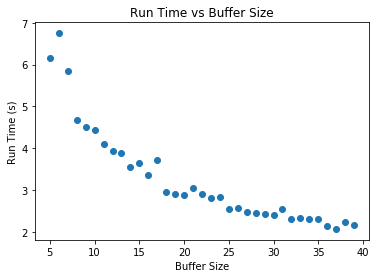

In [120]:
plt.scatter(b_range, np.mean(times, axis=1))
plt.ylabel('Run Time (s)')
plt.xlabel('Buffer Size')
plt.title('Run Time vs Buffer Size')
plt.show()

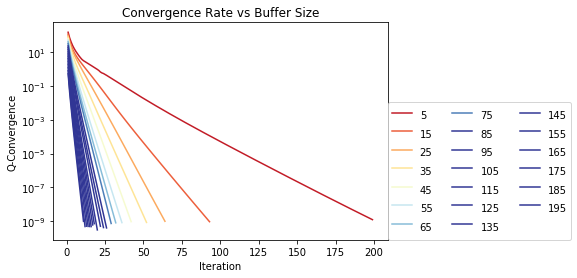

In [121]:
for b, tol_list in zip(b_big_range, big_tols):
    plt.plot(np.mean(tol_list, axis=0)[0:200], c = plt.cm.RdYlBu(3*b), label = str(b))
    

plt.yscale('log')
plt.ylabel('Q-Convergence')
plt.xlabel('Iteration')
plt.title('Convergence Rate vs Buffer Size')
plt.legend(loc=(1,0),ncol=3,handleheight=2.4, labelspacing=0.05)
plt.show()

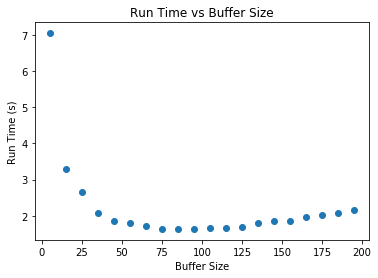

In [122]:
plt.scatter(b_big_range, np.mean(big_times, axis=1))
plt.ylabel('Run Time (s)')
plt.xlabel('Buffer Size')
plt.title('Run Time vs Buffer Size')
plt.show()

# Eigen Gap vs Iterations to Convergence

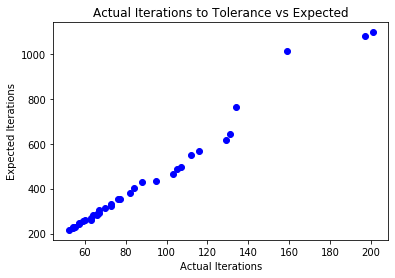

In [123]:
plt.scatter(np.mean(iters, axis=1), np.mean(e_iters, axis=1), c='blue')
plt.title("Actual Iterations to Tolerance vs Expected")
plt.ylabel('Expected Iterations')
plt.xlabel('Actual Iterations')
plt.show()

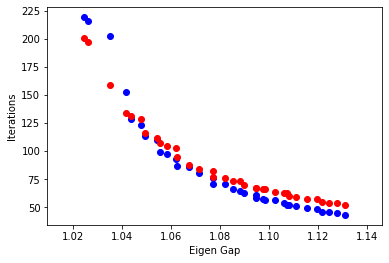

In [124]:
eigen_gaps = eigen_gap(S, 10, b_range)
plt.scatter(eigen_gaps, 1/5*np.mean(e_iters, axis=1), c='blue', label='Expected')
plt.scatter(eigen_gaps, np.mean(iters, axis=1), c='red', label='Actual')
plt.ylabel('Iterations')
plt.xlabel('Eigen Gap')
plt.show()

In [72]:
def eigen_gap(S, k, b):
    if isinstance(b, (int, float)):
        b = [b]
    if isinstance(S, da.core.Array):
        S = S.compute()
    gap = []
    for b_i in b:
        gap.append(S[k-1]/S[k+b_i:k+b_i+1])
    
    return np.array(gap)

def mean_eigen_gap(S, k, b):
    if isinstance(b, (int, float)):
        b = [b]
    gap = []
    for b_i in b:
        gap.append(S[k-1]/np.mean(S[k:k+b_i+1]))
    
    return np.array(gap)

def norm_2_eigen_gap(S, k, b):
    if isinstance(b, (int, float)):
        b = [b]
    gap = []
    for b_i in b:
        gap.append(np.sqrt(np.sum((np.square(S[k-1]/S[k:k+b_i+1])))))
    
    return np.array(gap)

def norm_half_eigen_gap(S, k, b):
    if isinstance(b, (int, float)):
        b = [b]
    gap = []
    for b_i in b:
        gap.append(np.sum((np.sqrt(S[k-1]/S[k:k+b_i+1]))))
    
    return np.array(gap)



ValueError: x and y must have same first dimension, but have shapes (16, 1) and (34,)

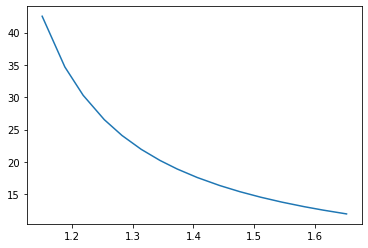

In [292]:
eigen_ratio = eigen_gap(S, k, b_range)[4:]
eigen_half_ratio = norm_half_eigen_gap(S, k, b_range)[4:]
plt.plot(eigen_ratio, _project_accuracy(4e-7,eigen_ratio, 1e-9))
#plt.plot(eigen_ratio, _project_accuracy(1.5e-7,eigen_half_ratio, 1e-9))
plt.plot(eigen_ratio, iters_test[4:])
#plt.plot(eigen_half_ratio, iters_test[4:])

In [181]:
eigen_ratio

array([[1.02383277],
       [1.02966306],
       [1.03205656],
       [1.03397079],
       [1.04217167],
       [1.04965966],
       [1.05038987],
       [1.05620704],
       [1.05722736],
       [1.06078287],
       [1.06514842],
       [1.07577675],
       [1.07828188],
       [1.08027364],
       [1.08346655],
       [1.08680994],
       [1.08778876],
       [1.09097142],
       [1.09520045],
       [1.09578846],
       [1.09768773],
       [1.10318289],
       [1.10626017],
       [1.10983663],
       [1.11417355],
       [1.12048945],
       [1.12387382],
       [1.12549342],
       [1.13025196],
       [1.13129136],
       [1.13336194],
       [1.13899293],
       [1.14175619],
       [1.14532189]])

In [182]:
eigen_half_ratio

array([ 7.05104851,  8.06577165,  9.0816735 , 10.09851704, 11.11938514,
       12.14391413, 13.16879942, 14.19651876, 15.22473438, 16.25467752,
       17.2867378 , 18.32393438, 19.3623379 , 20.40170004, 21.44259703,
       22.4850988 , 23.52806992, 24.5725657 , 25.61908395, 26.6658831 ,
       27.71358903, 28.76391417, 29.8157032 , 30.86919104, 31.92473524,
       32.98326698, 34.04339613, 35.10428888, 36.16742197, 37.23104378,
       38.29563851, 39.36287463, 40.43140455, 41.50160168])

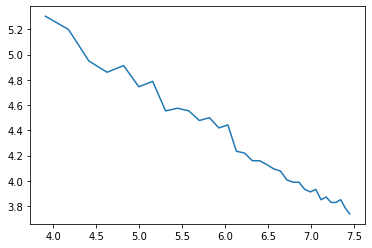

In [178]:
plt.plot(np.log(norm_half_eigen_gap(S, k, b_range)[4:]), np.log(iters_test[4:]))

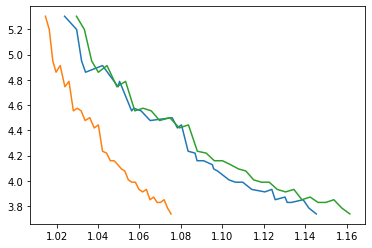

In [155]:
plt.plot(eigen_gap(S, k, b_range)[4:], np.log(iters_test[4:]))
plt.plot(mean_eigen_gap(S, k, b_range)[4:], np.log(iters_test[4:]))
plt.plot(norm_eigen_gap(S, k, b_range)[4:], np.log(iters_test[4:]))

In [227]:
PM = PowerMethod(max_iter=200, k=k, buffer=b, scoring_tol=1e-9, p=.2, sub_svd_start=False)
start = time.time()
_, _, _ = PM.svd(A)
print(time.time() - start )

Normal Start Method
6.573822021484375


In [228]:
len(PM.logs['tol'])

201

In [229]:
PM = PowerMethod(max_iter=200, k=k, buffer=b, scoring_tol=1e-9, p=.2, sub_svd_start=True)
start = time.time()
_, _, _ = PM.svd(A)
print(time.time() - start)

Normal Start Method
7.277191162109375


In [230]:
len(PM.logs['tol'])

201

In [231]:
PM.logs

{'tol': [nan,
  2687656.653072622,
  26.173421151800405,
  13.366292431495863,
  7.388504559342203,
  4.419053601784574,
  2.8003747325220205,
  1.8430402479592058,
  1.2414289236528948,
  0.8492519578296196,
  0.591872440777858,
  0.4253034506770902,
  0.3184542602121739,
  0.24921746595317623,
  0.20360224046709904,
  0.17359034674571075,
  0.1545223426260591,
  0.14317120763284938,
  0.1368958455305908,
  0.1335637028368898,
  0.1316534408921066,
  0.1302221895195956,
  0.1287564311023235,
  0.12701044288685168,
  0.12488594258709877,
  0.12235836096386431,
  0.11943724539232693,
  0.11614730282397374,
  0.11252048320954086,
  0.1085933437153314,
  0.10440657465820068,
  0.1000051381699216,
  0.09543832989785063,
  0.09075951469658662,
  0.08602549553807039,
  0.08129555832004294,
  0.0766302536597646,
  0.07208996221957688,
  0.0677332640057839,
  0.06361510875344603,
  0.059784780720214675,
  0.05628368310601752,
  0.053143047411210835,
  0.05038179786462485,
  0.04800493473205224